# Statistical Analysis of Women's Clothing E-Commerce Review Dataset
Women’s Clothing E-Commerce Reviews Dataset. This notebook uses only the reviews in its models for all the analysis. The labels are either positive or negative which says if the review is positive or negative. This task is called sentiment analysis.

In [13]:
import numpy as np
import pandas as pd
from matplotlib import pyplot as plt
from sklearn.metrics import roc_auc_score, f1_score, accuracy_score, confusion_matrix

# see http://stackoverflow.com/questions/1907993/autoreload-of-modules-in-ipython
from naive_bayes import *
from log_reg import *
%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [2]:
X_train, y_train, X_valid, y_valid, X_test = load_data(return_numpy=False)

In [3]:
train_df = pd.DataFrame(tuple(zip(X_train, y_train)), columns = ['review', 'sentiment'])
train_df.head()

,review,sentiment
0,Extremely comfortable t. fits tts. bought in b...,1
1,Perfect fall accessory and transitional piece ...,1
2,"Love, love, love but alas had to return. gorge...",1
3,I did not like this top at all-but had i looke...,0
4,Omg. i also bought this years ago. i have worn...,1


# BagOfWords Class

Implemented a Bag-of-Words model from scratching using natural language processing and information retrieval techniques. In this model, our reviews are represented as the bag (multiset) of its words, disregarding grammar and even word order but keeping multiplicity. This bag-of-words model serves as a backbone for calculating the review statistics.

## Custom Bag-of-Words Model

In [4]:
bow = BagOfWords(10)
vocab = bow.fit(X_train[:100])
counts = bow.transform(X_train[:100])
counts = counts.sum(0)

for word, count in zip(vocab, counts):
    print(f'{word:4}: {count}')

and : 232
but : 77
in  : 84
is  : 152
it  : 195
of  : 56
the : 340
this: 118
to  : 112
with: 62


## Sklearn Bag-of-Words Model

In [5]:
#  Sanity Check
# '[\w]{2,}' select all alpha-numerical chars that are at least 2 chars long
bow = CountVectorizer(token_pattern = '[\w]{2,}', max_features = 10)
bow = bow.fit(X_train[:100])
counts = bow.transform(X_train[:100]).sum(0)
for i in range(10):
    print(f'{bow.get_feature_names()[i]:4}: {counts[0, i]}')

and : 232
but : 77
in  : 84
is  : 152
it  : 195
of  : 56
the : 340
this: 118
to  : 112
with: 62


# Bayes Network

In statistics, the naive Bayes classifier is a "probabilistic classifier" based on applying Bayes' theorem with strong (naive) independence assumptions between the features. This section develops a Naive Bayes Classifier for a sentiment analysis task. At each entry/row of the input data X, only the Review Text feature is going to be used for classifying whether the review is positive or negative.

Posterior probability: $P(\text{class} | \text{review})$

Likelihood probability: $P(\text{review} | \text{class})$

Prior probability: $P(\text{class})$


## Preliminary Analysis

In [6]:
def naive_train(X_train, C, beta):
    N, V = X_train.shape
    priors  = np.zeros(C)
    likelihoods = np.zeros((C, V))
    
    for c in range(C):
        class_mask = y_train == c
        priors[c] = (class_mask.sum() + beta) / (N + (C * beta))
        likelihoods[c] = (X_train[class_mask].sum(0) + beta) / (X_train[class_mask].sum() + (V * beta))
    
    return priors, likelihoods

X_train = bow.transform(X_train)
priors, likelihoods = naive_train(X_train, 2, 1)

<BarContainer object of 2 artists>

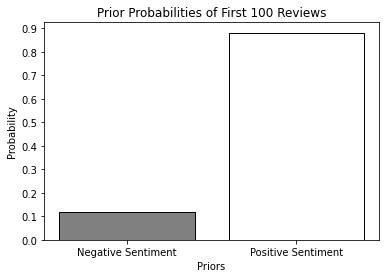

In [7]:
plt.title("Prior Probabilities of First 100 Reviews")
plt.yticks(np.arange(0, 1, step=0.1))
plt.ylabel('Probability')
plt.xlabel('Priors')
plt.bar(['Negative Sentiment', 'Positive Sentiment'], priors, color = ['gray', 'white'], edgecolor='black')

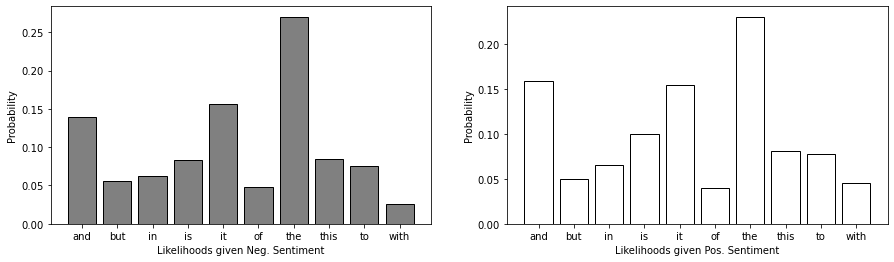

In [8]:
fig, ax = plt.subplots(nrows=1, ncols=2, figsize=(15,4))

ax[0].set(xlabel='Likelihoods given Neg. Sentiment', ylabel='Probability')
ax[0].bar(bow.get_feature_names(), likelihoods[0], color = 'gray', edgecolor='black') #row=0, col=0

ax[1].set(xlabel='Likelihoods given Pos. Sentiment', ylabel='Probability')
ax[1].bar(bow.get_feature_names(), likelihoods[1], color = 'white', edgecolor='black') #row=0, col=1


plt.show()

## Final Results
$F1 = 2 \cdot \dfrac{precision \cdot recall}{precision + recall} = \dfrac{TP}{TP + 0.5(FP + FN)}$

$Accuracy = \dfrac{TP + TN}{TP + FP + TN + FN}$

TP = true positive,
FP = false positive,
TN = true negative,
FN = false negative

In [9]:
X_train, y_train, X_valid, y_valid, X_test = load_data(return_numpy=True)

In [10]:
model = NaiveBayes(beta = 1)
NB_priors, NB_likelihoods = model.fit(X_train, y_train)
NB_posteriors, NB_y_pred = model.predict(X_valid)
conf_mat = confusion_matrix(y_valid, NB_y_pred)

In [11]:
print(f'roc auc: {roc_auc_score(y_valid, NB_y_pred)}')
print(f'f1     : {f1_score(y_valid, NB_y_pred)}')
print(f'acc    : {accuracy_score(y_valid, NB_y_pred)}')

roc auc: 0.8078631831377004
f1     : 0.9638799389520095
acc    : 0.9354349802970597


## Hyper-parameter tuning
The hyper parameter $\beta$ is used as a regularization constant to decrease variance in the bayes network.

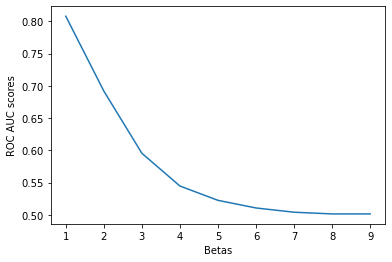

In [12]:
betas = []
scores = []
for i in range(1, 10):
    model = NaiveBayes(beta = i)
    NB_priors, NB_likelihoods = model.fit(X_train, y_train)
    NB_posteriors, NB_y_pred = model.predict(X_valid)
    score = roc_auc_score(y_valid, NB_y_pred)
    
    betas.append(i)
    scores.append(score)

plt.xlabel('Betas')
plt.ylabel('ROC AUC scores')
plt.plot(betas, scores)

# Logistic Regression

Logistic regression is a statistical model that in its basic form uses a logistic function to model a binary dependent variable, although many more complex extensions exist. In regression analysis, logistic regression (or logit regression) is estimating the parameters of a logistic model (a form of binary regression). This section implements l2-regularized Logistic Regression classifier from scratch. For optimization, this notebook uses gradient descent with constant learning rate. The task is to learn a classifier that can separate positive vs negative reviews

In [18]:
model = LogisticRegression(X_train.shape[1], reg = 1e-3)
loss_hist = model.gradDescent(X_train, y_train, 1, 200, verbose = True)
probs, y_pred = model.predict(X_valid)

print()
print(f'f1     :{score(y_valid, y_pred)}')
print(f'roc auc: {roc_auc_score(y_valid, y_pred)}')

Epoch :  100  loss :  0.2543159326555747
Epoch :  200  loss :  0.2137989727379827

f1     :0.9612794612794613
roc auc: 0.7706162889237482
